# Recommendation Sociale

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Chargement de données MovieLens

In [2]:
def loadMovieLens(fileTrain, fileTest):
    path='./recodata'
    ratingsTrain = []
    ratingsTest = []
    links = []
    users = set()
    movies = set()
    
    for line in open(path+fileTrain):
        (userId,movieId,rating,ts)=line.split('\t')
        ratingsTrain.append([userId, movieId, float(rating)])
        users.add(userId)
        movies.add(movieId)
    
    for line in open(path+'/u.links'):
        l = line.split('\t')
        i = l[0]
        if i in users:
            for j in l[1:]:
                if j in users:
                    links.append([i, j, 1])
    
    for line in open(path+fileTest):
        (userId,movieId,rating,ts)=line.split('\t')
        ratingsTest.append([userId, movieId, float(rating)])
    
    return ratingsTrain, ratingsTest, links

ratingsTrain, ratingsTest, links = loadMovieLens("/u1.train","/u1.test")
#print len(ratingsTrain) 
#print len(ratingsTest)
#print len(links)
u = np.random.randint(len(ratingsTrain)) 
user =   ratingsTrain[u][0]
item =   ratingsTrain[u][1]
rating = ratingsTrain[u][2]
U = {}
v = {}
k = 5
U[user] = np.random.rand(1,k)
v[item] = np.random.rand(k,1)
print (np.dot(U[user],v[item])[0][0])

#expUV = np.exp(self.u[user].dot(self.v[item])[0][0])

1.63931698182


# Modèle SoREC

In [3]:
class SoRec(object):
     def __init__(self, k, lambdaU=0.2, lambdaV=0.2, lambdaZ=0.2, eps=1e-5, tMax=1000):
        self.lambdaU = lambdaU
        self.lambdaV = lambdaV
        self.lambdaZ = lambdaZ
        self.k = k
        self.eps = eps
        self.tMax = tMax
    
     def fit(self, trainData, links):
        self.u = {}
        self.v = {}
        self.z = {}
        self.loss = []
        nbLoss = 0

        for t in range(self.tMax):
            #print (t)
            lossUV = 0
            lossUZ = 0
            for train in range(len(trainData)):
                #Ratings
                U = np.random.randint(len(trainData)) 
                user =   trainData[U][0]
                item =   trainData[U][1]
                Rij = trainData[U][2]
                if user not in self.u:
                    self.u[user] = np.random.rand(1,self.k)
                if item not in self.v:
                    self.v[item] = np.random.rand(self.k,1)
                
                self.u[user] = self.u[user] + self.eps * (Rij - (np.dot(self.u[user],self.v[item])[0][0])) * self.v[item].T
                self.v[item] = self.v[item] + self.eps * (Rij - (np.dot(self.u[user],self.v[item])[0][0])) * self.u[user].T
                lossUV += (Rij - (np.dot(self.u[user],self.v[item])[0][0]))**2 
                #nbLoss += 1
                #Links
                l = np.random.randint(len(links))
                personne = links[l][0]
                ami = links[l][1]
                confiance  = links[l][2]
                if personne not in self.u:
                    self.u[personne] = np.random.rand(1,self.k)
                if ami not in self.z:
                    self.z[ami] = np.random.rand(self.k,1)
                    
                self.u[personne] = self.u[personne] + self.eps  * (confiance - (np.dot(self.u[personne],self.z[ami])[0][0])) * self.z[ami].T
                self.z[ami] = self.z[ami] + self.eps * (confiance - (np.dot(self.u[personne],self.z[ami])[0][0])) * self.u[personne].T
                lossUZ += ((np.dot(self.u[personne],self.z[ami])[0][0]) - confiance)**2 
                # Regularisation 
                ru = np.random.choice(list(self.u.keys()))
                rv = np.random.choice(list(self.v.keys()))
                rz = np.random.choice(list(self.z.keys()))
                self.u[ru] = self.u[ru] * (1 + self.lambdaU * self.eps)
                self.v[rv] = self.v[rv] * (1 + self.lambdaV * self.eps)
                self.z[rz] = self.z[rz] * (1 + self.lambdaZ * self.eps)
                #lossReg = lossReg + np.sqrt((self.u[ru]**2).sum()) + np.sqrt((self.v[rv]**2).sum()) + np.sqrt((self.z[rz]**2).sum())
                
            self.loss.append((lossUV+lossUZ)/(len(trainData)*1.0))
            #print ((lossUV+lossUZ)/(len(trainData)*1.0))
        return self.loss
    
     def predict(self, testData):
        pred = []
        indice = []
        for ind,c in enumerate(testData):
            if (c[0] in self.u) and (c[1] in self.v) :
                pred.append(np.dot(self.u[c[0]], self.v[c[1]])[0][0])
                indice.append(ind)
        return pred, indice

# Apprentissage et test en utilisant 'u1.train' et 'u1.test'

In [4]:
sr = SoRec(5, eps=1e-4, tMax=50)
loss = sr.fit(ratingsTrain, links)

In [5]:
prediction, indice = sr.predict(ratingsTest)
mse = np.array((prediction - np.array(np.array(ratingsTest)[indice,2], float)) ** 2).mean()
#((pred - np.array(np.array(ratings_test)[:,2], float)) ** 2).mean()
print ("MSE : ",(mse))

('MSE : ', 1.4133416364311382)


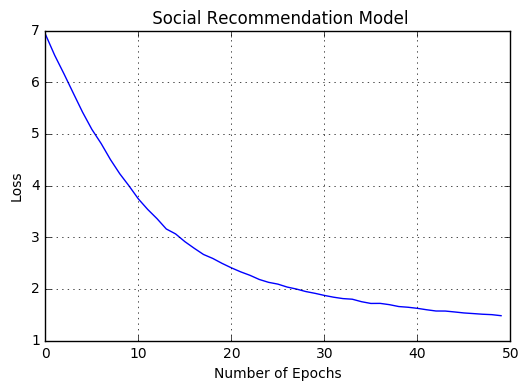

In [25]:
plt.plot(loss)
plt.title(' Social Recommendation Model')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()